# Stock Market Prediction and Forecasting using Stacked Bidirectional LSTM with big data

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tiingo import TiingoClient
import pandas as pd
from datetime import datetime

## Stock Data Collection

In [4]:
API_KEY = '045ee573e2f164700d7bb102340fdf3b23b8489c'
def get_data_set(stock_code):
    config = {
        'api_key': API_KEY,
        'session': True
    }

    client = TiingoClient(config)
    end_date = datetime(2023, 6, 30)  # Specify the desired end date
    start_date = end_date.replace(year=end_date.year - 10)  # Assuming 5 years of data

    df = client.get_dataframe(stock_code, frequency='daily', startDate=start_date, endDate=end_date)
    df.to_csv(f'{stock_code}.csv')
    df = pd.read_csv(f'{stock_code}.csv', index_col='date', parse_dates=True)

    return df

In [5]:
df = get_data_set('AAPL')

In [6]:
df.head()

,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
date,,,,,,,,,,,,
2013-07-01 00:00:00+00:00,409.22,412.27,401.22,402.69,13966200,12.687699,12.782263,12.439663,12.485239,391053991,0.0,1.0
2013-07-02 00:00:00+00:00,418.49,421.63,409.47,409.96,16780900,12.975112,13.072466,12.695450,12.710643,469865669,0.0,1.0
2013-07-03 00:00:00+00:00,420.80,422.98,417.45,420.86,8604600,13.046733,13.114323,12.942867,13.048593,240929040,0.0,1.0
2013-07-05 00:00:00+00:00,417.42,423.29,415.35,420.39,9786600,12.941937,13.123934,12.877757,13.034021,274025074,0.0,1.0
2013-07-08 00:00:00+00:00,415.05,421.00,410.65,420.11,10647800,12.868456,13.052933,12.732036,13.025339,298138698,0.0,1.0


In [7]:
df.tail()

,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
date,,,,,,,,,,,,
2023-06-26 00:00:00+00:00,185.27,188.05,185.23,186.83,48088661,185.27,188.05,185.23,186.83,48088661,0.0,1.0
2023-06-27 00:00:00+00:00,188.06,188.39,185.67,185.89,50730846,188.06,188.39,185.67,185.89,50730846,0.0,1.0
2023-06-28 00:00:00+00:00,189.25,189.90,187.60,187.93,51216801,189.25,189.90,187.60,187.93,51216801,0.0,1.0
2023-06-29 00:00:00+00:00,189.59,190.07,188.94,189.08,46347308,189.59,190.07,188.94,189.08,46347308,0.0,1.0
2023-06-30 00:00:00+00:00,193.97,194.48,191.26,191.63,85213216,193.97,194.48,191.26,191.63,85213216,0.0,1.0


In [8]:
close_column = df.reset_index()['close']
close_column.shape

(2518,)

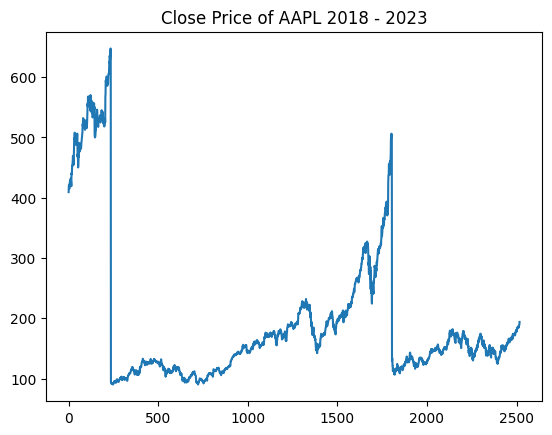

In [9]:
plt.title('Close Price of AAPL 2018 - 2023')
plt.plot(close_column)
plt.show()

## Data Preprocesing of Time-Series Data

### MinMax Scaling

In [10]:
close_column

0       409.22
1       418.49
2       420.80
3       417.42
4       415.05
         ...  
2513    185.27
2514    188.06
2515    189.25
2516    189.59
2517    193.97
Name: close, Length: 2518, dtype: float64

In [11]:
## LSTM is very sensitive to scale of Data, so we apply MinMax Scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
close_df = scaler.fit_transform(np.array(close_column).reshape(-1, 1))

In [12]:
print(close_df)

[[0.57253128]
 [0.58917192]
 [0.59331861]
 ...
 [0.17766169]
 [0.17827203]
 [0.1861346 ]]


In [13]:
close_df.shape

(2518, 1)

### Create Train Test Split

In [14]:
training_size = int(len(close_df)*0.8)
test_size = int(len(close_df)-training_size)
train_data, test_data = close_df[0:training_size, :], close_df[training_size:len(close_df)]

In [15]:
train_data[:20]

array([[0.57253128],
       [0.58917192],
       [0.59331861],
       [0.58725115],
       [0.58299675],
       [0.59610103],
       [0.59319296],
       [0.60496526],
       [0.60356867],
       [0.60523812],
       [0.61018364],
       [0.61039008],
       [0.61298939],
       [0.60076831],
       [0.60320965],
       [0.59006947],
       [0.62870016],
       [0.625092  ],
       [0.62956181],
       [0.64176854]])

In [16]:
training_size, test_size

(2014, 504)

In [17]:
train_data.size, test_data.size

(2014, 504)

### Converting an array of values to dataset matrix

In [18]:
# Convert an array of values to dataset matrix
def create_dataset(dataset, timestep=1):
  dataX, dataY = [], []
  for i in range(len(dataset)-timestep-1):
    a = dataset[i: i+timestep, 0]
    dataX.append(a)
    dataY.append(dataset[i+timestep, 0])
  return np.array(dataX), np.array(dataY)

In [19]:
TIME_STEPS = 150
X_train, y_train = create_dataset(train_data, TIME_STEPS)
X_test, y_test = create_dataset(test_data, TIME_STEPS)

In [20]:
X_train

array([[0.57253128, 0.58917192, 0.59331861, ..., 0.73509972, 0.73656812,
        0.73823756],
       [0.58917192, 0.59331861, 0.58725115, ..., 0.73656812, 0.73823756,
        0.75127004],
       [0.59331861, 0.58725115, 0.58299675, ..., 0.73823756, 0.75127004,
        0.75809144],
       ...,
       [0.05225555, 0.04981421, 0.05090922, ..., 0.07543038, 0.07844616,
        0.07794353],
       [0.04981421, 0.05090922, 0.04857558, ..., 0.07844616, 0.07794353,
        0.07742295],
       [0.05090922, 0.04857558, 0.04231066, ..., 0.07794353, 0.07742295,
        0.07688441]])

In [21]:
print(y_train)

[0.75127004 0.75809144 0.75794783 ... 0.07742295 0.07688441 0.07988224]


In [22]:
print(X_train.shape), print(y_train.shape)
print(X_test.shape), print(y_test.shape)

(1863, 150)
(1863,)
(353, 150)
(353,)


(None, None)

In [23]:
# Converting into 3-dimensional, so we can give the second and third dimension as input to the model
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [24]:
print(X_train.shape)
print(X_test.shape)

(1863, 150, 1)
(353, 150, 1)


In [25]:
print(y_train.shape)
print(y_test.shape)

(1863,)
(353,)



## Create a Stacked LSTM model

In [26]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Bidirectional, LSTM, Dense

In [27]:
model = Sequential()
model.add(Bidirectional(LSTM(128, return_sequences=True, input_shape=(150, 1))))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Bidirectional(LSTM(128)))
model.add(Dense(1))

In [29]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [30]:
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test), verbose=1)

Epoch 1/100
30/30 [==============================] - 26s 152ms/step - loss: 0.0131 - val_loss: 0.0016
Epoch 2/100
30/30 [==============================] - 2s 65ms/step - loss: 0.0033 - val_loss: 4.5036e-04
Epoch 3/100
30/30 [==============================] - 2s 65ms/step - loss: 0.0035 - val_loss: 6.7689e-04
Epoch 4/100
30/30 [==============================] - 2s 66ms/step - loss: 0.0029 - val_loss: 1.3707e-04
Epoch 5/100
30/30 [==============================] - 2s 65ms/step - loss: 0.0022 - val_loss: 2.9441e-04
Epoch 6/100
30/30 [==============================] - 2s 65ms/step - loss: 0.0029 - val_loss: 3.7213e-04
Epoch 7/100
30/30 [==============================] - 2s 65ms/step - loss: 0.0021 - val_loss: 1.4456e-04
Epoch 8/100
30/30 [==============================] - 2s 79ms/step - loss: 0.0018 - val_loss: 6.0642e-05
Epoch 9/100
30/30 [==============================] - 2s 66ms/step - loss: 0.0014 - val_loss: 5.6594e-05
Epoch 10/100
30/30 [==============================] - 2s 66ms/step

## Model Evaluation

In [31]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

12/12 [==============================] - 0s 19ms/step


In [32]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [33]:
from sklearn.metrics import mean_squared_error
import math
train_rmse = math.sqrt(mean_squared_error(y_train, train_predict))
test_rmse = math.sqrt(mean_squared_error(y_test, test_predict))

In [34]:
print(f'Training RMSE : {train_rmse}')
print(f'Testing RMSE : {test_rmse}')

Training RMSE : 211.73721256946538
Testing RMSE : 159.25774473869953


In [35]:
test_predict.shape

(353, 1)

## Predict the test data and plot the output

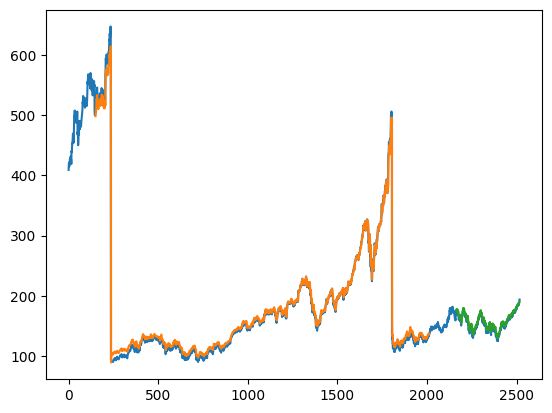

In [49]:
look_back = 150
trainPredict_plot = np.empty_like(close_df)
trainPredict_plot[:, :] = np.nan
trainPredict_plot[look_back : len(train_predict) + look_back , :] = train_predict

testPredict_plot = np.empty_like(close_df)
testPredict_plot[:, :] = np.nan
testPredict_plot[len(train_predict) + (look_back*2) + 1 : len(close_df) - 1, :] = test_predict

plt.plot(scaler.inverse_transform(close_df))
plt.plot(trainPredict_plot)
plt.plot(testPredict_plot)
plt.show()

## Predict the Future 30 days and plot the output

In [50]:
len(test_data)

504

In [51]:
timestep = 150
X_input = test_data[len(test_data)-timestep:].reshape(1, -1)
X_input.shape

(1, 150)

In [52]:
temp_input=list(X_input)
temp_input=temp_input[0].tolist()
temp_input

[0.10912452654065016,
 0.10381101118351374,
 0.09682804674457426,
 0.09135297179887622,
 0.10366740266034788,
 0.1041700324914284,
 0.10327247922164182,
 0.10115425350494553,
 0.09447645717773348,
 0.09094009729477445,
 0.09400972947744449,
 0.09313012727305367,
 0.09731272551025907,
 0.09907192991904071,
 0.09501498913960546,
 0.08296982425906976,
 0.07939756224531924,
 0.07555603425063279,
 0.07543037679286269,
 0.08108496239251797,
 0.07530471933509253,
 0.0746405299154505,
 0.07135548494803168,
 0.0641930098551349,
 0.07060154020141099,
 0.07117597429407438,
 0.062451756511748974,
 0.06476744394779829,
 0.06236200118477031,
 0.0706194912668067,
 0.07157089773278044,
 0.07261205952573282,
 0.07756655357495468,
 0.07742294505178882,
 0.07984633888021253,
 0.08196456459690882,
 0.08065413682302047,
 0.08076184321539484,
 0.08542912021828497,
 0.09124526540650188,
 0.0937943166926957,
 0.09259159531118175,
 0.09636131904428527,
 0.09989767892724435,
 0.0946380167662951,
 0.096953704202

In [53]:
# demonstrate prediction for next 10 days
from numpy import array

lst_output=[]
n_steps=150
i=0
while(i<30):

    if(len(temp_input)>150):
        #print(temp_input)
        X_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,X_input))
        X_input=X_input.reshape(1,-1)
        X_input = X_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(X_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        X_input = X_input.reshape((1, n_steps,1))
        yhat = model.predict(X_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


print(lst_output)

[0.18662103]
151
1 day input [0.10381101 0.09682805 0.09135297 0.1036674  0.10417003 0.10327248
 0.10115425 0.09447646 0.0909401  0.09400973 0.09313013 0.09731273
 0.09907193 0.09501499 0.08296982 0.07939756 0.07555603 0.07543038
 0.08108496 0.07530472 0.07464053 0.07135548 0.06419301 0.07060154
 0.07117597 0.06245176 0.06476744 0.062362   0.07061949 0.0715709
 0.07261206 0.07756655 0.07742295 0.07984634 0.08196456 0.08065414
 0.08076184 0.08542912 0.09124527 0.09379432 0.0925916  0.09636132
 0.09989768 0.09463802 0.0969537  0.09900013 0.10867575 0.11528174
 0.1103093  0.11555101 0.11065037 0.10876551 0.10901682 0.11411492
 0.1129481  0.11677168 0.11386361 0.11178128 0.1044752  0.1052471
 0.1061267  0.10129786 0.10346994 0.10255444 0.09878471 0.09986178
 0.10905272 0.11407902 0.11007593 0.11235572 0.10826288 0.1045111
 0.10804746 0.11185309 0.11257113 0.11770514 0.1161793  0.12048755
 0.12386235 0.12125945 0.12323406 0.1256036  0.12206724 0.12093633
 0.12653706 0.12939128 0.13395085 0.

In [ ]:
day_new = np.arange(1, 152)
day_pred = np.arange(len(close_df) + 1, len(close_df) + len(lst_output) + 1)

In [72]:
len(close_df)

2518

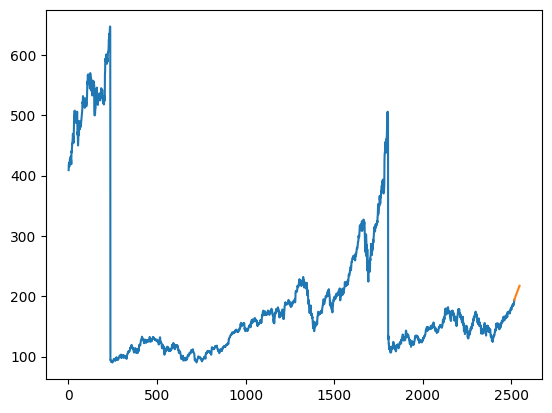

In [76]:
plt.plot(day_new, scaler.inverse_transform(close_df))
plt.plot(day_pred, scaler.inverse_transform(lst_output))
plt.show()

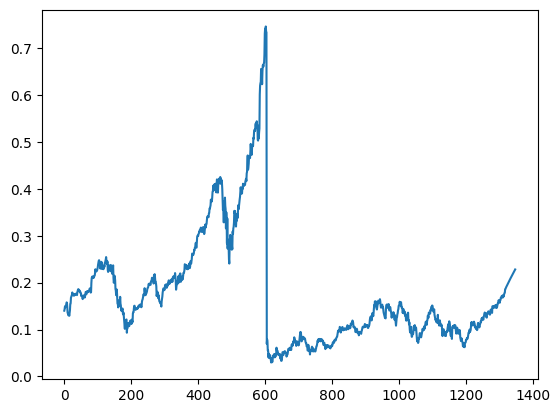

In [74]:
df3=close_df.tolist()
df3.extend(lst_output)
plt.plot(df3[1200:])

In [77]:
model.save('./Deep Learning Models/stock_bidirectional_lstm_model.h5')